# Posterior uncertainties

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, ivpsolvers, solution
from probdiffeq.doc_util import notebook
from probdiffeq.statespace import recipes
from probdiffeq.strategies import filters, smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

Set an example problem.

Solve the problem on a low resolution and short time-span to achieve large uncertainty.

In [3]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

## Filter

In [5]:
ts0 = ivpsolvers.MLESolver(filters.Filter(*recipes.ts0_iso()))
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [6]:
# %#%time

sol = ivpsolve.solve_and_save_at(
    vf,
    initial_values=(u0,),
    save_at=ts,
    solver=ts0,
    rtol=1e-2,
    atol=1e-2,
    parameters=f_args,
)

Plot the solution

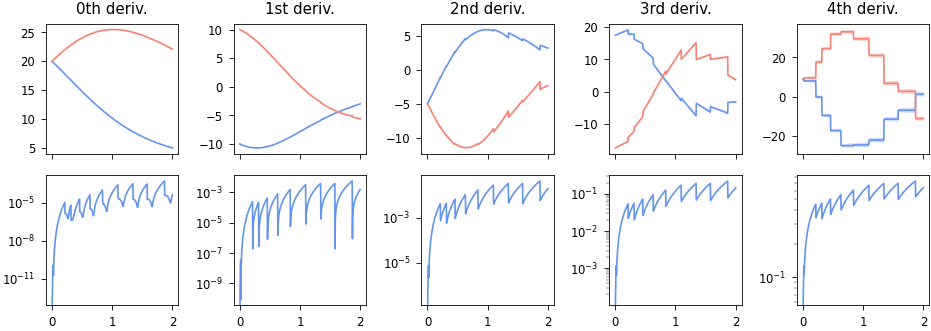

In [7]:
_, num_derivatives, _ = sol.marginals.hidden_state.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 3),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = sol.marginals.hidden_state.mean[:, i, :]
    ls = sol.marginals.hidden_state.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(sol.t, ms, marker="None")
    for m in ms.T:
        axes_cols[0].fill_between(sol.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(sol.t, stds, marker="None")

plt.show()

## Smoother

In [8]:
ts0 = ivpsolvers.MLESolver(smoothers.FixedPointSmoother(*recipes.ts0_iso()))
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [9]:
# %#%time

sol = ivpsolve.solve_and_save_at(
    vf,
    initial_values=(u0,),
    save_at=ts,
    solver=ts0,
    rtol=1e-2,
    atol=1e-2,
    parameters=f_args,
)

In [10]:
key = jax.random.PRNGKey(seed=1)
u, samples = solution.sample(key, solution=sol, shape=(2,), solver=ts0)

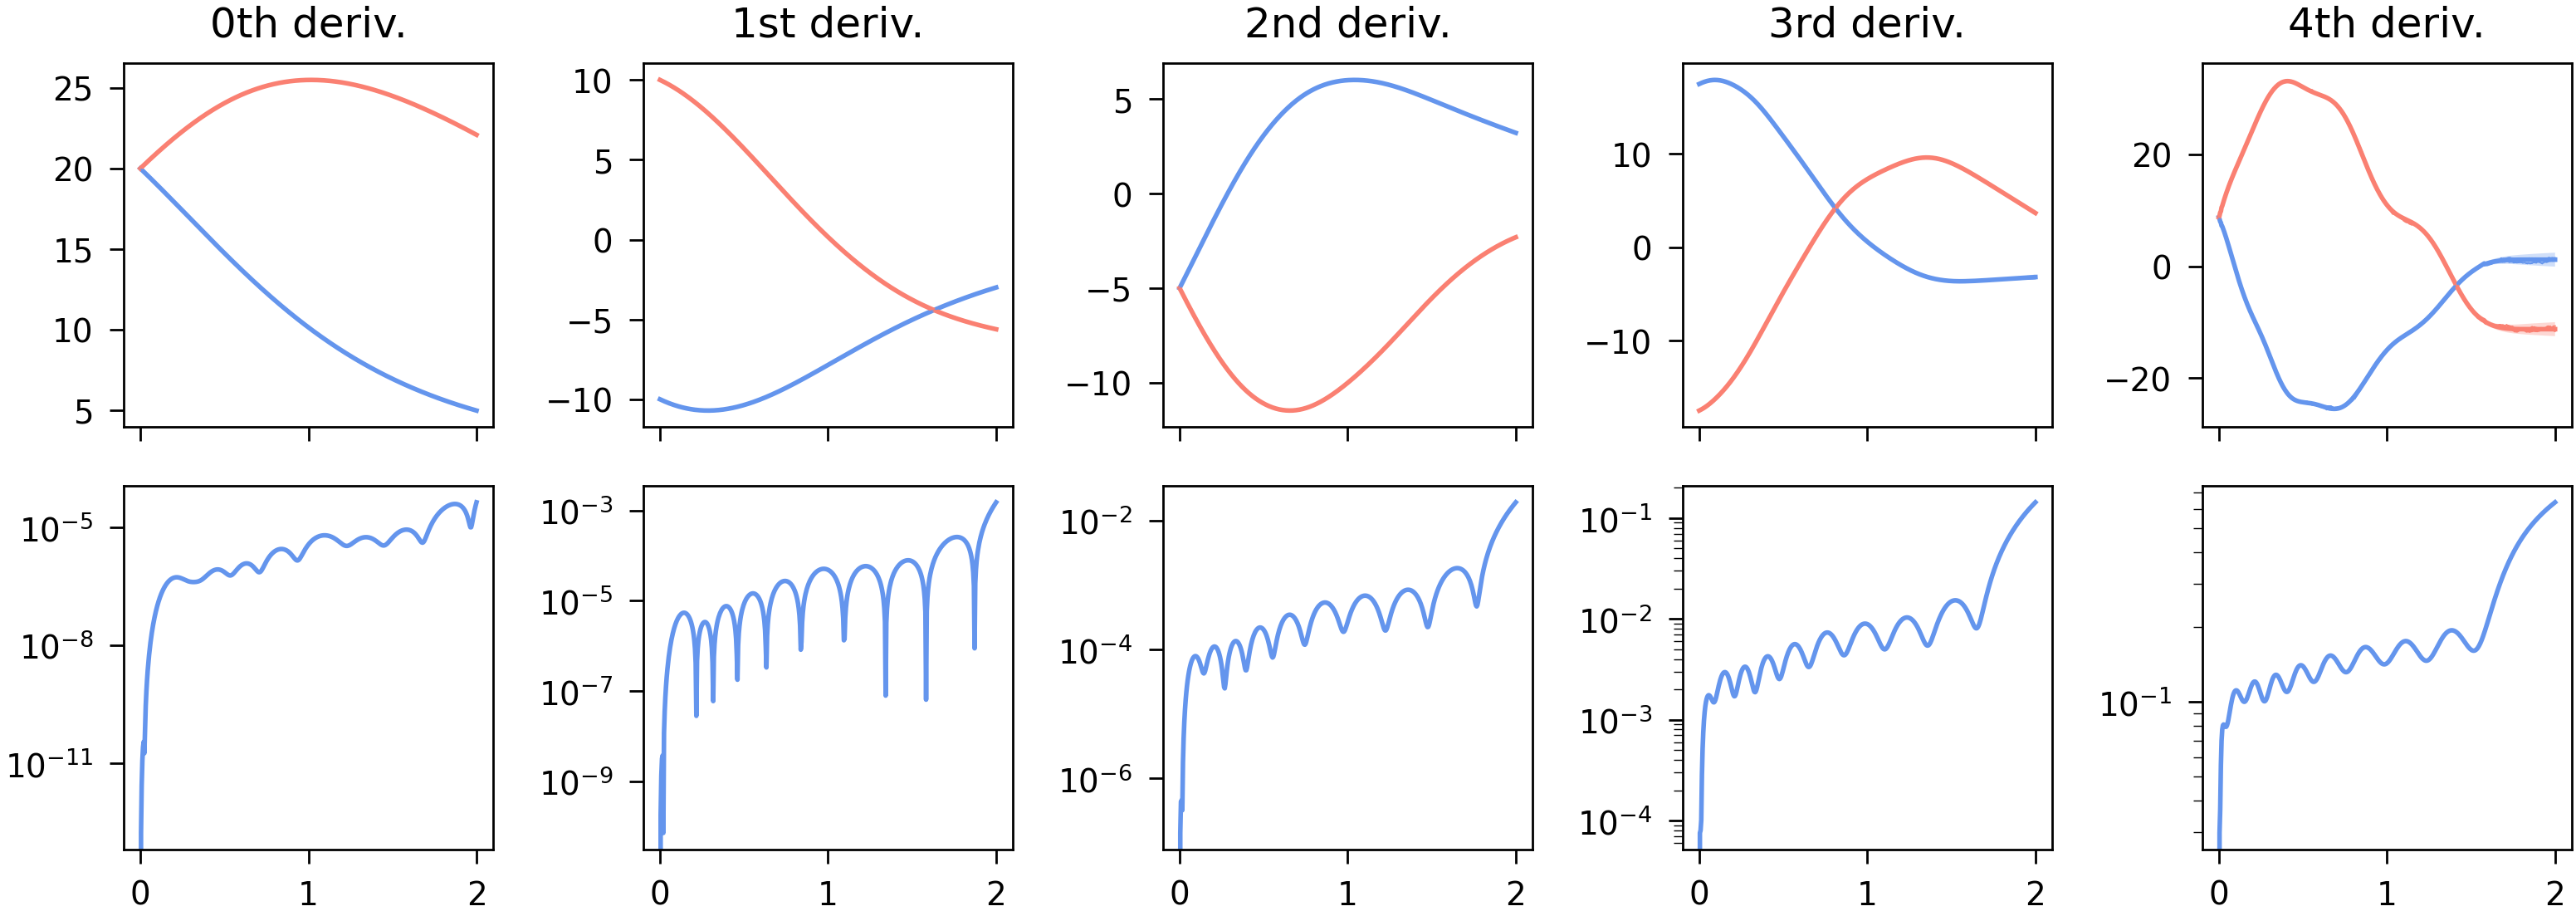

In [12]:
_, num_derivatives, _ = sol.marginals.hidden_state.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 3),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = sol.marginals.hidden_state.mean[:, i, :]
    samps = samples[..., i, :]
    ls = sol.marginals.hidden_state.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(sol.t, ms, marker="None")
    for s in samps:
        axes_cols[0].plot(sol.t, s[..., 0], color="C0", linewidth=0.35, marker="None")
        axes_cols[0].plot(sol.t, s[..., 1], color="C1", linewidth=0.35, marker="None")
    for m in ms.T:
        axes_cols[0].fill_between(sol.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3)

    axes_cols[1].semilogy(sol.t, stds, marker="None")

plt.show()

The marginal standard deviations (bottom row) show how the filter is forward-only, whereas the smoother is a global estimate.

This is why you should use a filter for terminal-value simulation and a smoother if you want "global" solutions.